In [1]:
import numpy as np
import pandas as pd
from ratings_graph import RatingsGraph
from baseline_debiaser import debias_ratings_baseline
import matplotlib.pyplot as plt

## Working Synthetic Data

In [2]:
# Working 2x2 example of synthetic dataset

# num_users, num_entities = 100, 50

# ground_truth_ratings = np.zeros(num_entities)
# ground_truth_ratings[type_1_entities] = 0.3
# ground_truth_ratings[np.logical_not(type_1_entities)] = 0.7

# ratings_matrix = np.zeros((num_users, num_entities))
# ratings_matrix[type_A_users[:, None].dot(type_1_entities[None, :])] = 0.6
# ratings_matrix[type_A_users[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(type_1_entities[None, :])] = 0.1
# ratings_matrix[np.logical_not(type_A_users)[:, None].dot(np.logical_not(type_1_entities)[None, :])] = 0.5

In [3]:
def gen_ratings_graph(rating_sparseness, user_type_counts, entity_type_counts, ground_truth_fn, user_type_ratings):
    '''
    rating_sparseness: percentage of ratings actually present
    user_types_prob: probability that user is type A vs B
    movie_type_prob: probability that movie is type 1 vs 2
    ground_truth: 2x1 matrix, ground truth each type movie
    user_biases: 2x2 matrix with user bias for each movie type
    '''
    num_users, num_entities = np.sum(user_type_counts), np.sum(entity_type_counts)
    ratings_graph = np.random.rand(num_users, num_entities) <= rating_sparseness #0.4
    
    user_types = np.random.permutation(np.repeat(np.arange(user_type_counts.shape[0]), user_type_counts))
    entity_types = np.random.permutation(np.repeat(np.arange(entity_type_counts.shape[0]), entity_type_counts))
    
    ground_truth_ratings = np.vectorize(ground_truth_fn)(entity_types)
    
    ratings_matrix = np.zeros((num_users, num_entities))
    for user_type in range(user_type_counts.shape[0]):
        for entity_type in range(entity_type_counts.shape[0]):
            user_entity_type_mask = (user_types == user_type)[:, None].dot((entity_types == entity_type)[None, :])
            ratings_matrix[user_entity_type_mask] = user_type_ratings(user_type, entity_type)
            
    return ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types

In [36]:
def ground_truth_rating_fn(entity_type):
    return 0.6 if entity_type == 1 else 0.3

def user_type_rating_fn(user_type, entity_type):
    if user_type == 0:
        return ground_truth_rating_fn(entity_type) + 0.4
    else:
        return ground_truth_rating_fn(entity_type) - 0.1

ratings_graph, ratings_matrix, ground_truth_ratings, user_types, entity_types = gen_ratings_graph(0.1, \
                                                                        (1000*np.array([0.5, 0.5])).astype(int), \
                                                                        (500*np.array([0.5, 0.5])).astype(int), \
                                                                        ground_truth_rating_fn,
                                                                        user_type_rating_fn)
synthetic_graph = RatingsGraph(ratings_graph, ratings_matrix, ground_truth_ratings=ground_truth_ratings)
#biases_1, true_ratings_1, errors_1 = debias_ratings_baseline(synthetic_graph, 0.2, 1000)
biases, true_ratings, errors = debias_ratings_baseline(synthetic_graph, 0.1, 1.00, 1000, 0.01)

In [37]:
len(errors)

942

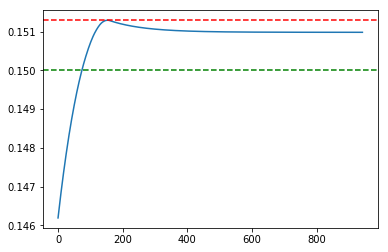

In [38]:
mean_pred = np.sum(ratings_matrix*ratings_graph, axis=0)/synthetic_graph.get_entity_rating_counts()
mean_pred_error = np.sqrt(np.mean((mean_pred - ground_truth_ratings)**2))

ratings_graph_na = ratings_graph.copy()
ratings_graph_na[ratings_graph_na==0]=np.nan
median_pred = np.nanmedian(ratings_matrix*(ratings_graph_na), axis=0)
median_pred_error = np.sqrt(np.mean((median_pred - ground_truth_ratings)**2))
#plt.plot(errors_1, label='alpha=0.2')
plt.plot(errors)
plt.axhline(mean_pred_error, color='r', linestyle='--')
plt.axhline(median_pred_error, color='g', linestyle='--')
plt.legend()
plt.show()

In [32]:
print mean_pred[:10]
print median_pred[:10]

[0.70792079 0.45263158 0.75294118 0.46442308 0.74545455 0.43232323
 0.76923077 0.75       0.73684211 0.74456522]
[0.75 0.45 0.75 0.45 0.75 0.45 0.75 0.75 0.75 0.75]


In [8]:
best_iter = np.argmin(errors)
#true_ratings[best_iter]
#print(best_iter)
#np.sort(np.abs(biases[best_iter - 1] - biases[best_iter]))
print true_ratings[-1][:10]

[0.76350377 0.45977083 0.7453174  0.44999741 0.7499616  0.48648174
 0.75377034 0.43494548 0.75488281 0.74054656]


In [9]:
ground_truth_ratings[:10]

array([0.6, 0.3, 0.6, 0.3, 0.6, 0.3, 0.6, 0.3, 0.6, 0.6])

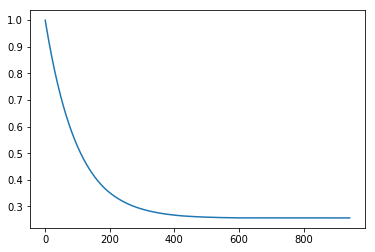

In [15]:
plt.plot([np.max(np.absolute(bias)) for bias in biases])
plt.show()

In [16]:
np.max(np.absolute(biases[-1]))

0.25698106675670035

In [20]:
[(user_types[i]+1, bias) for i, bias in enumerate(biases[-1])]

[(2, -0.25170249176932674),
 (2, -0.2475038666008748),
 (1, 0.25037922719764205),
 (2, -0.2551376378400039),
 (2, -0.2488958895418837),
 (1, 0.24995711989293515),
 (2, -0.2478344036757288),
 (2, -0.24741196856247347),
 (2, -0.24833688305086746),
 (1, 0.24576508053738416),
 (1, 0.24925444784991155),
 (1, 0.24891515979354645),
 (2, -0.25001946906758626),
 (1, 0.25106116561912684),
 (2, -0.25112675468555934),
 (1, 0.251360318871384),
 (1, 0.25482943417787224),
 (2, -0.2530776328584846),
 (1, 0.24716826415955018),
 (1, 0.24406363581557572),
 (2, -0.24733966816724748),
 (1, 0.24402121287263953),
 (1, 0.24932954529286006),
 (2, -0.24414890350085994),
 (2, -0.2474233023186753),
 (1, 0.25434286623388747),
 (1, 0.24766394240194897),
 (2, -0.24751061885031259),
 (1, 0.24898691961065858),
 (1, 0.24936048848737782),
 (2, -0.24896152145031464),
 (2, -0.24411258218715606),
 (2, -0.24948530539625455),
 (2, -0.24369419306606616),
 (1, 0.242001791374033),
 (1, 0.249245448293061),
 (1, 0.254099995621479